# real-estate

## Abstract

This report goes explores a highly dimensional dataset on properties to find a regression model for the sale price. During the first analysis stage, the data dimensions are reduced from 82 to ~30. Further reductions are achieved by closer analysis.

It was found that methods such as PCA (on the continuous part of the data), MCA (on the categorical parts of the data) and factor analysis did not result in explainable attributes, and thus could not be used to reduce the dimensions much further.

In the end, a Ridge regression model was chosen, with $\lambda = 8$. This model provided a fairly low MAE = 0.15, but also a fairly low R^2 $\approx$ 0.48. 

The highlight of this project has been in it's use of the pandas_profiling library to quickly remove attributes that are deemed uninportant.

## Scope and Objectives

The purpose of this notebook is to develop a regression model for the sale price of houses. 

Note that the author, at this point in time, is otherwise occupied with other work and has thus been unable to perform a comprehensive analysis for this project.

Therefore, to accelerate the process, the author placed a great amount of importance into using an external library, pandas_profiling, to accelerate the process of reducing dimensions.

Justifications for removing all of the variables will not be provided, but some specific examples will be.

The project objectives are to:

1) develop a regression model that could predict the sale price of property

2) reduce the dimensions of the data

3) explore specifically the concept of PCA, MCA and factor analysis for dimensionality reduction

## Libraries

In [1]:
# ICDSS
from PythonFiles import reader as r

# mathematical
import numpy as np

# data storage / analysis
import pandas as pd
from pandas_profiling import ProfileReport

# dimensional reduction / statistical analysis
import prince
from sklearn.decomposition import PCA
from scipy.stats import skew as skewness

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot

# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# modelling
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

# evaluation
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE

## Exploration - Reducing Dimensions

In [2]:
path = 'Data/data.csv'
df = r.get_housing_data(path) # unnecessary change to your function, just did this out of curiosity
df.head()

,Order,PID,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


**NOTE:** running the next 3 cells (already commneted) will take a considerable amount of time. The outcome of these 3 cells can be found in 'Reporting/profile.html'. 

In [3]:
#profile = df.profile_report()

In [4]:
#profile

In [5]:

#profile.to_file('Reporting/profile.html')

In [6]:
df_temp = df.copy()

# drop attributes which contain > 30% missing values
df_temp.drop(['PoolQC','Fence','Alley','FireplaceQu','MiscFeature'], axis = 1, inplace = True)

# drop attributes that are redundant / meaningless based on our knowledge
df_temp.drop(['Order','PID','SaleType'], axis = 1, inplace = True)

# drop attributes that have very little correlation with everything (based on the correlation graph generated)
df_temp.drop(['3SsnPorch', 'ScreenPorch','PoolArea',
              'MiscVal','MoSold','YrSold','MSZoning',
              'MSSubClass','LotFrontage','LotArea',
              'LotShape','LotConfig','BldgType',
              'HouseStyle'], axis = 1, inplace = True)

# drop attributes that are highly skewed with weak correlations
# Examples: 99.5% of 'street' is 'Pave'

df_temp.drop(['Street','LandContour','Utilities','LandSlope',
              'Condition1','Condition2','RoofMatl','BsmtCond','PavedDrive',
              'KitchenAbvGr','Functional','EnclosedPorch','CentralAir',
              'GarageCond','GarageQual','BsmtHalfBath','LowQualFinSF','Electrical',
              'LandContour','LandSlope','ExterCond'], axis = 1, inplace = True)

# drop values that may mislead our analysis (this includes things that are incorrectly
# stored, for instance: year remod/add = year constructed if no remodelling as been done)
df_temp.drop(['YearRemod/Add','GarageCars'],axis = 1, inplace = True)

df_temp.head()

,Neighborhood,OverallQual,OverallCond,YearBuilt,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,...,TotRmsAbvGrd,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageArea,WoodDeckSF,OpenPorchSF,SaleCondition,SalePrice
0,NAmes,6,5,1960,Hip,BrkFace,Plywood,Stone,112.0,TA,...,7,2,Attchd,1960.0,Fin,528.0,210,62,Normal,215000
1,NAmes,5,6,1961,Gable,VinylSd,VinylSd,None,0.0,TA,...,5,0,Attchd,1961.0,Unf,730.0,140,0,Normal,105000
2,NAmes,6,6,1958,Hip,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,...,6,0,Attchd,1958.0,Unf,312.0,393,36,Normal,172000
3,NAmes,7,5,1968,Hip,BrkFace,BrkFace,None,0.0,Gd,...,8,2,Attchd,1968.0,Fin,522.0,0,0,Normal,244000
4,Gilbert,5,5,1997,Gable,VinylSd,VinylSd,None,0.0,TA,...,6,1,Attchd,1997.0,Fin,482.0,212,34,Normal,189900


In [7]:
# replace missing values with median for numerical, mode for categorical
# note that for these columns, the percentage of missing values is < 6% (except for LotFrontage at 16.7%)
for column in df_temp.columns:
    if df_temp[column].dtypes in ['int64', 'float64']:
        df_temp[column] = df_temp[column].fillna(df_temp[column].median())
    else:
        df_temp[column] = df_temp[column].fillna(df_temp[column].mode()[0])

In [8]:
# verify that data types are correct (some nominal values may be read as 'int')
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 39 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Neighborhood   2930 non-null   object 
 1   OverallQual    2930 non-null   int64  
 2   OverallCond    2930 non-null   int64  
 3   YearBuilt      2930 non-null   int64  
 4   RoofStyle      2930 non-null   object 
 5   Exterior1st    2930 non-null   object 
 6   Exterior2nd    2930 non-null   object 
 7   MasVnrType     2930 non-null   object 
 8   MasVnrArea     2930 non-null   float64
 9   ExterQual      2930 non-null   object 
 10  Foundation     2930 non-null   object 
 11  BsmtQual       2930 non-null   object 
 12  BsmtExposure   2930 non-null   object 
 13  BsmtFinType1   2930 non-null   object 
 14  BsmtFinSF1     2930 non-null   float64
 15  BsmtFinType2   2930 non-null   object 
 16  BsmtFinSF2     2930 non-null   float64
 17  BsmtUnfSF      2930 non-null   float64
 18  TotalBsm

In [9]:
# change variables that have incorrect data types
# example: the year a building was built should not be continuous data
df_temp[['GarageYrBlt','YearBuilt']] = df_temp[['GarageYrBlt','YearBuilt']].astype(str)

In [10]:
#profile_temp = df_temp.profile_report()


In [11]:
#profile_temp

In [12]:
#profile_temp.to_file('Reporting/profile2.html')

In [13]:
# further cancellations
df_temp2 = df_temp.copy()
df_temp2.drop(['BsmtFinType2','BsmtFinSF2','Heating',
              'BsmtFullBath','HalfBath','BedroomAbvGr',
               'WoodDeckSF','OpenPorchSF','RoofStyle'], axis =1, inplace = True)

df_temp2.head()

,Neighborhood,OverallQual,OverallCond,YearBuilt,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,Foundation,...,FullBath,KitchenQual,TotRmsAbvGrd,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageArea,SaleCondition,SalePrice
0,NAmes,6,5,1960,BrkFace,Plywood,Stone,112.0,TA,CBlock,...,1,TA,7,2,Attchd,1960.0,Fin,528.0,Normal,215000
1,NAmes,5,6,1961,VinylSd,VinylSd,None,0.0,TA,CBlock,...,1,TA,5,0,Attchd,1961.0,Unf,730.0,Normal,105000
2,NAmes,6,6,1958,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,CBlock,...,1,Gd,6,0,Attchd,1958.0,Unf,312.0,Normal,172000
3,NAmes,7,5,1968,BrkFace,BrkFace,None,0.0,Gd,CBlock,...,2,Ex,8,2,Attchd,1968.0,Fin,522.0,Normal,244000
4,Gilbert,5,5,1997,VinylSd,VinylSd,None,0.0,TA,PConc,...,2,TA,6,1,Attchd,1997.0,Fin,482.0,Normal,189900


For the time being, reducing the initial 82 attributes to 30 has been good. Since the remaining values are somewhat intercorrelated (highly, at least in comparison to the previous varriables), it might be wise to perform some other dimensionality reduction methods, such as PCA.

In [14]:
(df_temp2.dtypes == 'object').value_counts(True)

True     0.533333
False    0.466667
dtype: float64

Given that almost half of the attributes are actually categorical variables, this makes it difficult to justify the use of PCA analysis (one-hot encoded variables will not fix the problem, due to the way PCA operates). As a result, a factor analysis (this *sort of* combines MCA and PCA) will be used to reduce the dimensions even further.

## Exploration - Reducing dimensions

In [15]:
# normalize non-object data
scaler = StandardScaler()

df_temp3 = df_temp2.copy()
df_temp3[df_temp3.columns[(df_temp3.dtypes != 'object')]] =\
scaler.fit_transform(df_temp3[df_temp3.columns[(df_temp3.dtypes != 'object')]])

df_temp3.head()

,Neighborhood,OverallQual,OverallCond,YearBuilt,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,Foundation,...,FullBath,KitchenQual,TotRmsAbvGrd,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageArea,SaleCondition,SalePrice
0,NAmes,-0.067254,-0.506718,1960,BrkFace,Plywood,Stone,0.061046,TA,CBlock,...,-1.024793,TA,0.354167,2.162180,Attchd,1960.0,Fin,0.256673,Normal,0.428229
1,NAmes,-0.776079,0.393091,1961,VinylSd,VinylSd,None,-0.566039,TA,CBlock,...,-1.024793,TA,-0.917535,-0.925143,Attchd,1961.0,Unf,1.196325,Normal,-0.948957
2,NAmes,-0.067254,0.393091,1958,Wd Sdng,Wd Sdng,BrkFace,0.038650,TA,CBlock,...,-1.024793,Gd,-0.281684,-0.925143,Attchd,1958.0,Unf,-0.748103,Normal,-0.110125
3,NAmes,0.641571,-0.506718,1968,BrkFace,BrkFace,None,-0.566039,Gd,CBlock,...,0.784028,Ex,0.990018,2.162180,Attchd,1968.0,Fin,0.228763,Normal,0.791305
4,Gilbert,-0.776079,-0.506718,1997,VinylSd,VinylSd,None,-0.566039,TA,PConc,...,0.784028,TA,-0.281684,0.618518,Attchd,1997.0,Fin,0.042693,Normal,0.113980


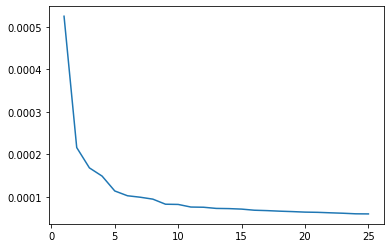

In [16]:
famd = prince.FAMD(
    n_components = 25,
    n_iter = 10
)
famd = famd.fit(df_temp3.drop('SalePrice', axis='columns'))

plt.plot([i for i in range(1,26)],famd.eigenvalues_)

Based on the above, it suffices to say that Factor Analysis does not in fact provide suitable results (this is because the eigenvectors are all below 1). Let's try to see if we can reduce either the dimensions of the categorical data using MCA, or that of the continuous data using PCA

In [17]:
pca = PCA(
    n_components = 13
)

df_numerical = df_temp3[df_temp3.columns[df_temp3.dtypes != 'object']]
df_categorical = df_temp3[df_temp3.columns[df_temp3.dtypes == 'object']]

Y= pca.fit_transform(np.asarray(df_numerical.drop('SalePrice', axis = 1)))
pca.explained_variance_ratio_.cumsum()
# choosing n_components = 8 will retain 94% of the variance, while reducing our
# dimensions by 6

array([0.37946506, 0.541568  , 0.65629858, 0.73109708, 0.7892547 ,
       0.84299349, 0.89360116, 0.9310594 , 0.96184037, 0.98190582,
       0.99627207, 0.99973005, 1.        ])

In [18]:
pca = PCA(
    n_components = 8
)

df_numerical = pca.fit_transform(np.asarray(df_numerical.drop('SalePrice', axis =1)))


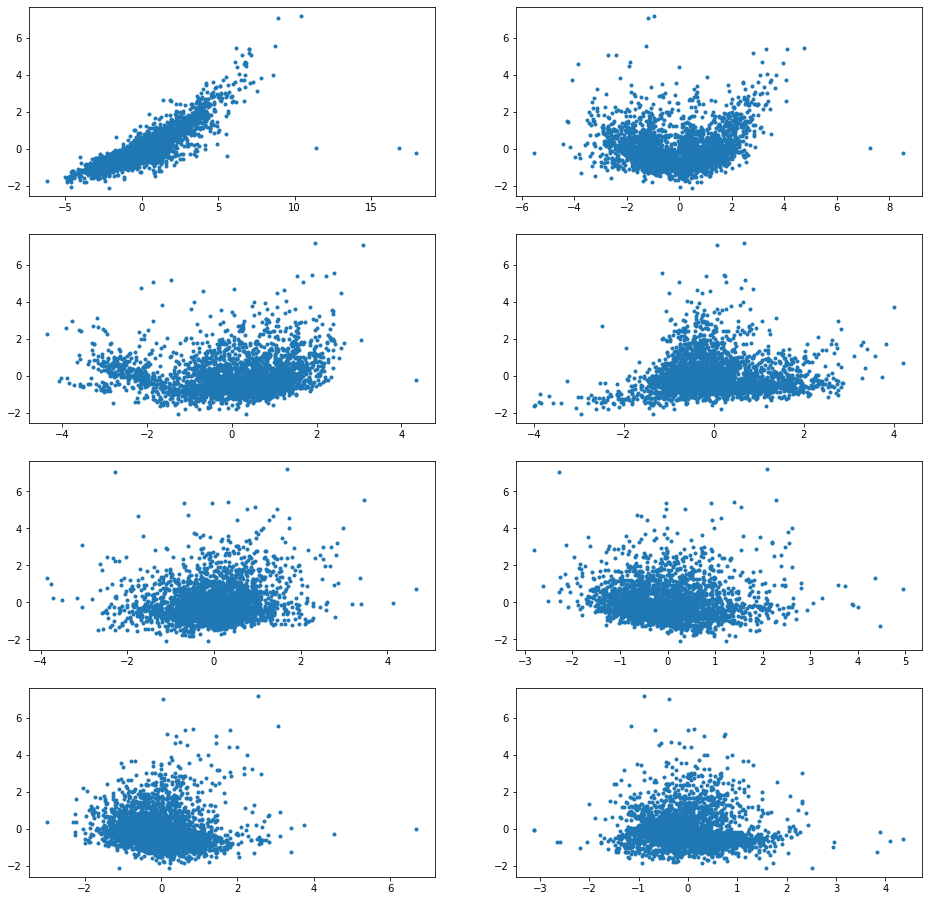

In [19]:
fig = plt.figure(figsize = (16,16))
for i in range(8):
    fig.add_subplot(4,2,i+1)
    plt.plot(df_numerical[:,i], df_temp3['SalePrice'],'.')

# not exactly convinced by the outcome of the PCA

This method of reducing the dimensions of the variables is not convincing, and in fact is problematic: we've essentially *lost* the meaning of the variables. So, even if the PCA (or factor analysis for that matter) gave us 4-5 variables in total, the models produced would not be insightful since we'd struggle to interpret them.

## Modelling

In [20]:
# convert categorical varialbes to dummy ones
df_numerical = df_temp3[df_temp3.columns[df_temp3.dtypes != 'object']]
df_dummies = pd.get_dummies(data = df_categorical)

df_temp4 = pd.concat([df_numerical, df_dummies], axis = 1)
df_temp4.shape

(2930, 351)

Since we are interested in modelling the sale price, we are not exactly interested in understanding why outliers occur. As such, it might be worth removing them. 

To do this, we need to examine how skewed out datasets are. If they are extremely skewed, then we may benefit from performing a de-skewing transformation before removing outliers (as this would make the outlier removal symmetric).

In [21]:
skewnesses = []
for i in df_numerical.columns:
    skew = skewness(df_numerical[i])
    if skew > 1:
        print(i,skew)
        df_numerical[i+'_sqrt'] = np.sqrt(np.abs(df_numerical[i]))
        df_numerical.drop(i,axis =1, inplace = True)
        skew = skewness(df_numerical[i+'_sqrt'])
        print(skew)
    skewnesses.append(skew)

print(skewnesses)

MasVnrArea 2.617963998324404
1.9702088872979078
BsmtFinSF1 1.4158419280826164
0.1553685450409307
TotalBsmtSF 1.155940093771022
0.5559528948227693
1stFlrSF 1.4686762661218562
0.42946802802703704
GrLivArea 1.2734573491164036
0.41592648700706814
SalePrice 1.7426073719460107
0.7622221826160221
[0.19053634796661897, 0.5741353586783584, 1.9702088872979078, 0.1553685450409307, 0.9229302418336044, 0.5559528948227693, 0.42946802802703704, 0.866013109137272, 0.41592648700706814, 0.171864034915623, 0.7531567344138045, 0.7388367095522604, 0.2418772530171526, 0.7622221826160221]


/Users/yousefnami/python_environments/ICDSS_Challenges/real-estate/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/yousefnami/python_environments/ICDSS_Challenges/real-estate/lib/python3.7/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


<AxesSubplot:>

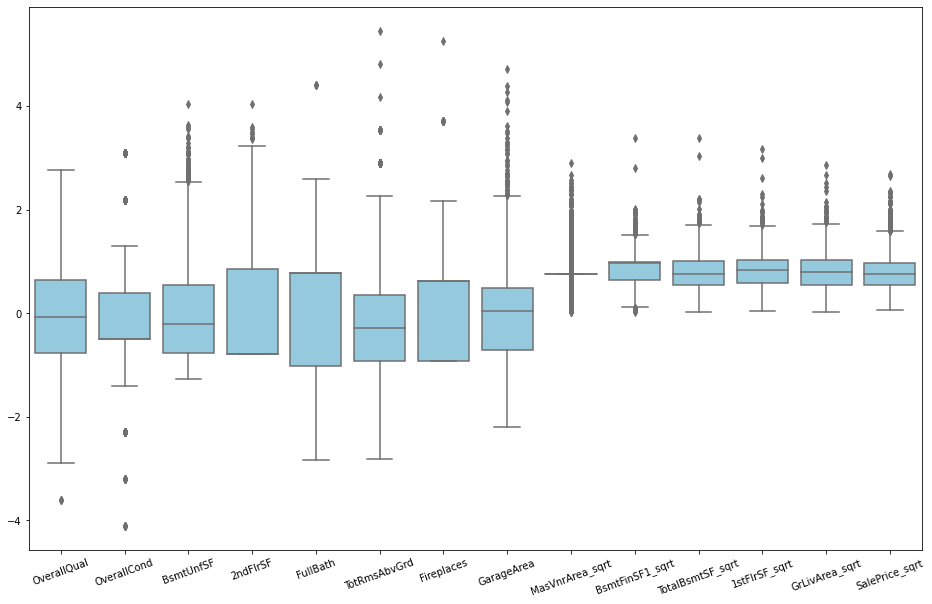

In [22]:
# remove outliers

fig, ax = plt.subplots(figsize = (16,10))
ax = sns.boxplot(ax = ax,data=df_numerical, orient="v", color="skyblue")
ax.set_xticklabels(ax.get_xticklabels(), rotation=20)
ax

Seeing as the MasVnrArea was mostly comprised of outliers, it was decided to explore this a bit further.

It's worth noting that this attribute still remained higlhy skewed, even after transformation. It is mostly comprised of zeroes, however it seems to be correlated with house SalePrice.

<AxesSubplot:xlabel='MasVnrArea'>

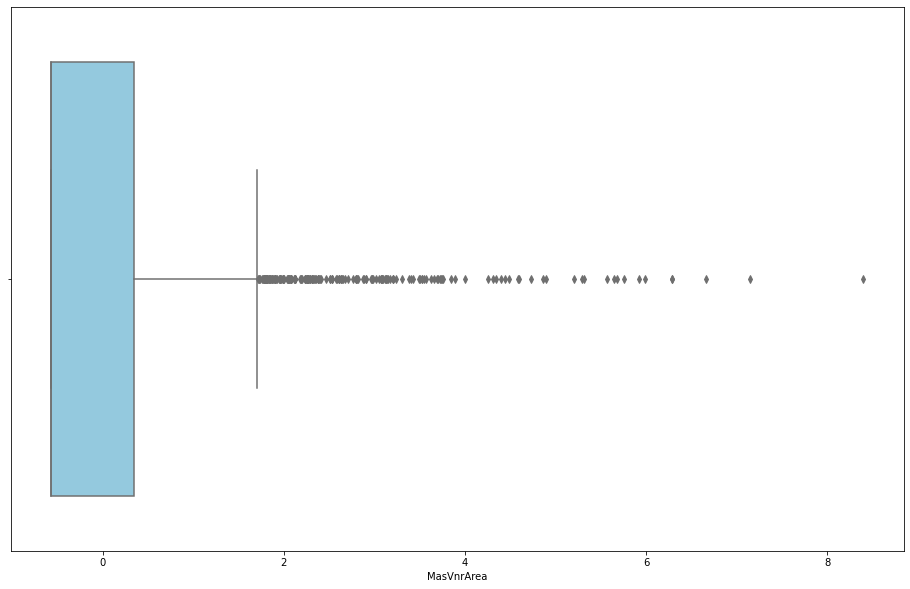

In [23]:
# examine the box plot for this attribute before transfrmation
fig, ax = plt.subplots(figsize = (16,10))
ax = sns.boxplot(ax = ax,x=df_temp4['MasVnrArea'], orient="h", color="skyblue")
ax

<AxesSubplot:xlabel='MasVnrArea'>

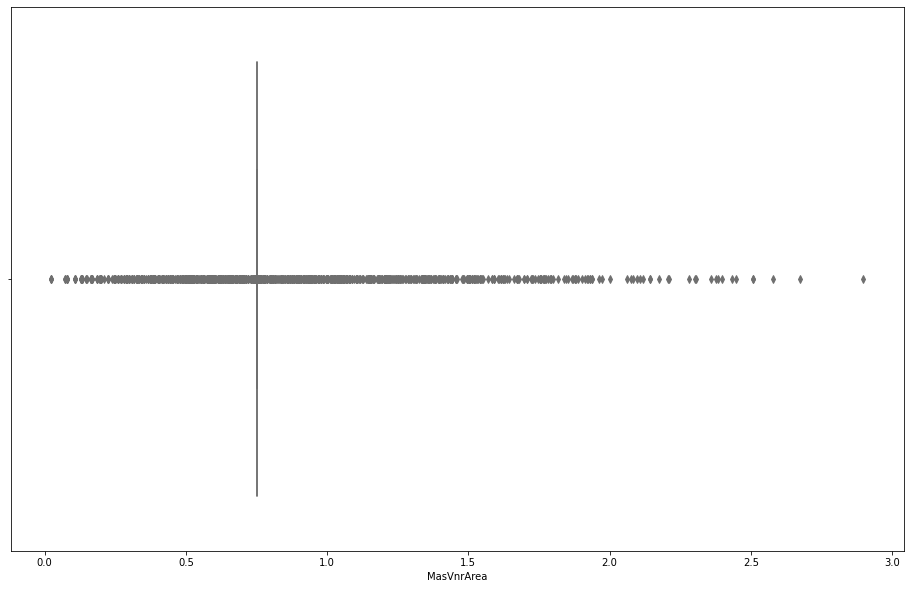

In [24]:
fig, ax = plt.subplots(figsize = (16,10))
ax = sns.boxplot(ax = ax,x=np.sqrt(np.abs(df_temp4['MasVnrArea'])), orient="h", color="skyblue")
ax

Upon further inspection, it makes sense that this is, somewhat expected. That said, it would be illogical to consdier anything over UQ + 1.25IQR and anything lower than LQ - 1.25IQR as outliers, since thst would essentially kill the dataset.

An alternative approach would be to define more stringent conditions for this particular attribute, so for instance UQ + $\gamma$IQR, where $\gamma$ is set to a high value. However, even this is arbitrary, and we have no knowledge of what value to set. 

With that in mind, it was decided to dock this attribute off.

In [25]:
df_numerical.drop('MasVnrArea_sqrt', axis =1 , inplace= True)

/Users/yousefnami/python_environments/ICDSS_Challenges/real-estate/lib/python3.7/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [26]:
# remove  values that exceed UQ + 1.25IQR and those below LQ - 1.25IQR

for i in df_numerical.columns:
    LQ = df_numerical[i].quantile(0.25)
    UQ = df_numerical[i].quantile(0.75)
    IQR = UQ - LQ
    df_numerical = df_numerical[(df_numerical[i] < 1.25*IQR + UQ) &
                                (df_numerical[i] > LQ - 1.25*IQR)
                               ]
df_numerical.shape[0]/2930

0.7064846416382252

In [31]:
# dataset has been decreased by 30%

# now only store the indices that are relevant

df_temp5 = df_numerical.copy()

df_temp5 = pd.concat([df_temp5, df_dummies.iloc[df_temp5.index]], axis = 1)

df_temp5.to_csv('Data/data_reduced.csv')

df_temp5.shape # correctly concatenated

(2070, 350)

/Users/yousefnami/python_environments/ICDSS_Challenges/real-estate/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='SalePrice_sqrt'>

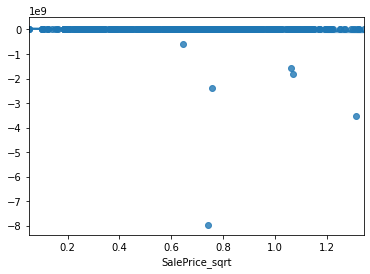

In [32]:
X = df_temp5[df_temp5.columns[df_temp5.columns != 'SalePrice_sqrt']]
y = df_temp5['SalePrice_sqrt']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3)

model = LinearRegression()
model.fit(X_train,y_train)
y_hat = model.predict(X_test)

sns.regplot(y_test, y_hat)

Clearly, using a linear regression does not seem appropriate. We see that the model is punished by very large errors. This suggests that our method of removing outliers (by removing values exceeding UQ + 1.25IQR and those lower than LQ - 1.25IQR) has not been entirely successful. This calls for using more sophisticated methods of regression.

/Users/yousefnami/python_environments/ICDSS_Challenges/real-estate/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


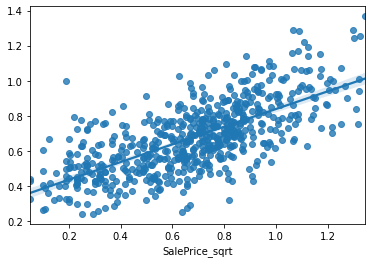

In [33]:
model = Ridge()
model.fit(X_train,y_train)
y_hat = model.predict(X_test)
sns.regplot(y_test, y_hat)
plt.show()

Note: here we invoked the use of the Ridge regression technique, because of it's regularisation parameter ($\lambda$) that decreases the effect of high errors. It's important to note that changing this value will affect the bias and variance of the model. Increasing it will lead to a high balance, but low variance, whereas a decrease causes the opposite. Let's plot to see what the most suitable value is.

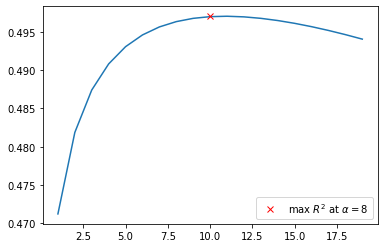

In [34]:
r2 = []
for i in range(1, 20):
    model = Ridge(alpha = i)
    model.fit(X_train,y_train)
    y_hat = model.predict(X_test)
    r2.append(r2_score(y_test,y_hat))
    
    
l1 = plt.plot([i for i in range(1,20)], r2)
l2 = plt.plot(r2.index(max(r2)),max(r2),'rx')
plt.legend(l2,['max $R^2$ at $\\alpha = 8$'])

## Evaluating model performance

As seen from above, the $R^2$ of the model is fairly low. However, this could be due to high variance in the data. We can get a better understanding of how good the model is by exploring some other error metrics.

In [35]:
model = Ridge(alpha = 8)
model.fit(X_train,y_train)
y_hat = model.predict(X_test)
MAE(y_test, y_hat)

0.1534685119873217

It seems upon closer inspection that the model has not in fact performed terribly. The low R^2 value is merely suggestive of the fact that the data has high variance.

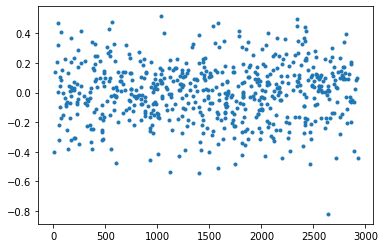

In [36]:
# check the data for heteroscedasticity
error = y_test - y_hat
plt.plot(error,'.')

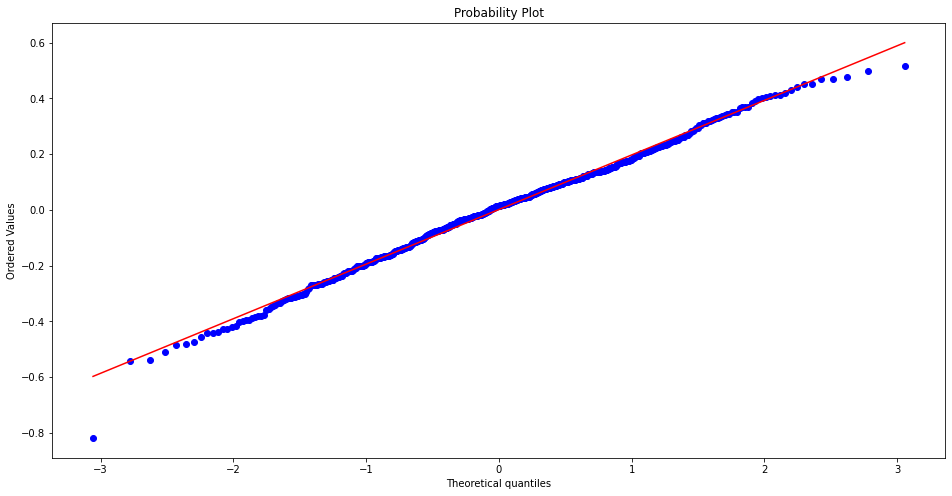

In [37]:
# check errors for normality
fig, ax = plt.subplots(figsize=(16,8))
probplot(error, plot = ax)
plt.show()

From the two plots above, it is clear that the assumption of normal errors is valid.

(array([  3.,  22., 125., 168.,  23.,   5.,   2.,   0.,   0.,   1.]),
 array([-0.13755083, -0.09250332, -0.04745582, -0.00240832,  0.04263918,
         0.08768668,  0.13273418,  0.17778168,  0.22282918,  0.26787668,
         0.31292418]),
 <BarContainer object of 10 artists>)

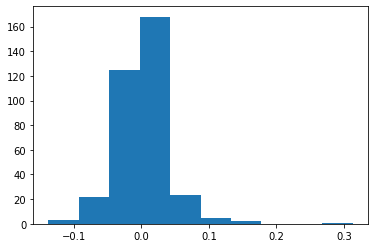

In [38]:
# explore the ridge coefficients
coefficients = pd.DataFrame(data = {'Attribute':X.columns, 'Coefficient':model.coef_})
plt.hist(coefficients['Coefficient'])

Based on the above histogram, we can see that there is no 'single' model that is highly important, however, the vast majority fall within the 0 range. This suggests that the vast majority do not add much to the model.

This can be examined further.

# Conclusions and Further work

In this mini-project, a highly dimensional dataset on properties was explored. The aim of the project was to decrease the dimensions of the data, explore the data to understand some of the underlying principles, get exposed to PCA analysis, get exposed to Lasso and Ridge regression, and then choose a suitable model for a first iteration of the project.

By the end of the notebook, it is clear that a Ridge regression model works best (compared with a LinearRegression model and a Lasso model (not shown in Notebook)). The resulting model has a fairly low R^2, but a good value for absolute error.

Further iterations of the project should look into the following:
- more creative solutions to reduce dimensions in the model
- comparison of different models, and using advanced metrics such as AIC to determine the best settings
- it would be interesting to see how a neural network would reduce the dimensions (Self organising map)